# Importing Libraries and Pre-Processing

In [3]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [5]:
### Importing and Preparing Data
# load dataset
training_data = pd.read_csv('train_x.csv').to_numpy()
training_label = pd.read_csv('train_y.csv').to_numpy().flatten()
testing_data = pd.read_csv('test_x.csv').to_numpy()
testing_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {training_data.shape}, y = {training_label.shape}')
print(f'Full test data:  X = {testing_data.shape}, y = {testing_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [7]:
full_train_data = np.reshape(training_data, (training_data.shape[0], 32, 32, 3))
test_data = np.reshape(testing_data, (testing_data.shape[0], 32, 32, 3))
full_train_label = training_label
test_label = testing_label
print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 32, 32, 3), y = (50000,)
Full test data:  X = (10000, 32, 32, 3), y = (10000,)


In [8]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), visualize=False, multichannel=True, 
                 block_norm='L2-Hys')
        fd_array[i] = fd
    return fd_array

In [9]:
tic = timeit.default_timer()
full_train_data_hog = extract_hog(full_train_data)
test_data_hog = extract_hog(test_data)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

time elapsed: 0:06:22.246217


In [10]:
# Training and Validation Set Split
train_data_hg, val_data_hg, train_label, val_label = train_test_split(
    full_train_data_hog, full_train_label, test_size = 0.3,
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data_hg.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data_hg.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3780), y = (35000,)
Validation data:  X = (15000, 3780), y = (15000,)


In [11]:
# Dimensionality Reduction - PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components = 0.8, whiten=True, random_state=0))
tic = timeit.default_timer()
X_train_hg = pca_scaled2.fit_transform(train_data_hg)
X_val_hg = pca_scaled2.transform(val_data_hg)
toc = timeit.default_timer()
print(f"time elapsed:              {timedelta(seconds=toc-tic)}")
print(f"PCA train data shape:      {X_train_hg.shape}")
print(f"PCA validation data shape: {X_val_hg.shape}")

time elapsed:              0:02:08.057676
PCA train data shape:      (35000, 460)
PCA validation data shape: (15000, 460)


# Classification

### Naive Bayes

In [14]:
# GridSearch Search
parameters = {
 'priors': [None]
 }

In [17]:
gnb = GaussianNB()
gnb_grid = GridSearchCV(
    estimator = gnb, param_grid = parameters, cv = 10, verbose = 2, n_jobs = -1)
tic = timeit.default_timer()
gnb_grid.fit(X_train_hg, train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.3s finished


time elapsed: 0:00:01.639836


In [18]:
gnb_results = pd.DataFrame(gnb_grid.cv_results_)
print(gnb_grid.best_params_)
print(gnb_grid.best_score_)                 # 0.26420000000000005
print(gnb_grid.score(X_val_hg, val_label))  # 0.2674
# 

{'priors': None}
0.26420000000000005
0.2674


In [20]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(PCA(n_components=0.8, whiten=True, random_state=0))
gnbmod = GaussianNB()
gnb_pipe = make_pipeline(pca_pipe, gnbmod)
tic = timeit.default_timer()
gnb_pipe.fit(full_train_data_hog, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 1149.32 seconds

time elapsed: 0:02:35.640003


In [21]:
print(f"Train accuracy: {gnb_pipe.score(full_train_data_hog, full_train_label)}") # 1
print(f"Test accuracy:  {gnb_pipe.score(test_data_hog, test_label)}")             # 0.5647

Train accuracy: 0.33788
Test accuracy:  0.3304


In [22]:
# Model prediction
pred = gnb_pipe.predict(test_data_hog)

Accuracy: 0.330
Confusion matrix:
[[147  85  36  18 249  73  11  62 269  50]
 [ 30 461  14  22  64  56  70  37 178  68]
 [ 27  33 100  48 415 169  54  71  64  19]
 [ 23  45  50 120 273 236  96  67  43  47]
 [  9  23  56  50 652  74  36  58  29  13]
 [ 10  24  74  75 250 366  63  76  21  41]
 [ 11  59  31  39 390  82 256  46  57  29]
 [ 15  20  66  41 227 138  50 377  23  43]
 [ 49  96  24  24 203  32  19  19 490  44]
 [ 50  86  37  27 125  98  40  55 147 335]]


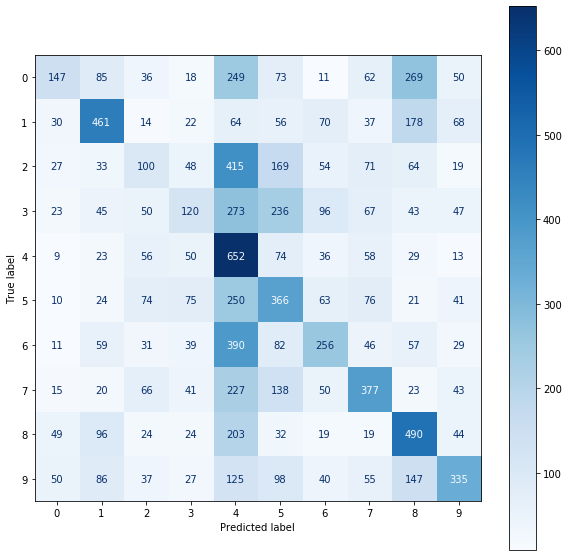

In [23]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_gnb.png")

In [24]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.40      0.15      0.21      1000
           1       0.49      0.46      0.48      1000
           2       0.20      0.10      0.13      1000
           3       0.26      0.12      0.16      1000
           4       0.23      0.65      0.34      1000
           5       0.28      0.37      0.31      1000
           6       0.37      0.26      0.30      1000
           7       0.43      0.38      0.40      1000
           8       0.37      0.49      0.42      1000
           9       0.49      0.34      0.40      1000

    accuracy                           0.33     10000
   macro avg       0.35      0.33      0.32     10000
weighted avg       0.35      0.33      0.32     10000



In [25]:
# Save model file with pickle
gnb_pickle = "Pickle_GNB_hfull.pkl"  

with open(gnb_pickle, 'wb') as file:  
    pickle.dump(gnb_pipe, file)

In [5]:
# Load model from file with pickle
gnb_pickle = "Pickle_GNB_hfull.pkl" 
with open(gnb_pickle, 'rb') as file:  
    pickled_gnb = pickle.load(file)

pickled_gnb

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=1,
                                                learning_rate=0.1, loss='auto',
                                                max_bins=255, max_depth=10,
                                                max_iter=2000,
                             